### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../stack-overflow-developer-survey-results-2023/survey_results_clean_usa.csv")

In [3]:
df.head()

,Age,Employment,RemoteWork,EdLevel,YearsCodePro,DevType,ConvertedCompYearly,Industry,OrgSize,ICorPM,SalaryBracket
0,25-34 years old,"Employed, full-time",Remote,Bachelors,9.0,"Senior Executive (C-Suite, VP, etc.)",285000.0,"Information Services, IT, Software Development...",Less than 20 employees,People manager,High
1,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Bachelors,23.0,"Developer, back-end",250000.0,"Information Services, IT, Software Development...","5,000 to 9,999 employees",Individual contributor,High
2,35-44 years old,"Employed, full-time",Remote,Some College,3.0,"Developer, full-stack",135000.0,"Information Services, IT, Software Development...","1,000 to 4,999 employees",Individual contributor,Low-Mid
3,25-34 years old,"Employed, full-time",Remote,Bachelors,9.0,"Developer, full-stack",75000.0,Other,Less than 20 employees,Individual contributor,Low
4,55-64 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Some College,15.0,"Developer, full-stack",130000.0,"Manufacturing, Transportation, or Supply Chain",100 to 499 employees,Individual contributor,Low-Mid


In [4]:
salary_ranges = {
    'Low' : '40k - 105k',
    'Low-Mid' : '105.5k - 135k',
    'Mid' : '135.5k - 162k',
    'Mid-High' : '162.5k - 200k',
    'High' : '200.4k - 300k',
}

### Encoding the features before fitting the model

In [5]:
from sklearn.preprocessing import LabelEncoder

def label_encode_column(df, column, encoder_dict=None):
    if encoder_dict is None:
        encoder_dict = {}

    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    encoder_dict[column] = le

    return df, encoder_dict

encoders = {}

# Encode individual columns
columns_to_encode = ['Age', 'Employment', 'RemoteWork', 'DevType', 'Industry', 'OrgSize', 'ICorPM']

for column in columns_to_encode:
    df, encoders = label_encode_column(df, column, encoders)

# Ordinal Encoding for Education Level
education_level_map = {'Primary School': 0, 'Secondary School': 1, 'Some College': 2, 'Associate degree': 3,
                       'Bachelors': 4, 'Masters': 5, 'PhD, Postdoc': 6}
df['EdLevel'] = df['EdLevel'].map(education_level_map)

# Mapping for Salary Bracket
salary_mapping = {'Low': 0, 'Low-Mid': 1, 'Mid': 2, 'Mid-High': 3, 'High': 4}
df['SalaryBracketEncoded'] = df['SalaryBracket'].map(salary_mapping)

### Loading the Test Set and encoding the features

In [6]:
test_df = pd.read_csv("../stack-overflow-developer-survey-results-2023/test_set_usa_2023.csv")

In [7]:
# Label Encoding for categirical columns in test set
for column,encoder in encoders.items():
    test_df[column] = encoder.transform(test_df[column])

# Ordinal Encoding for Education Level
test_df['EdLevel'] = test_df['EdLevel'].map(education_level_map)

# Mapping for Salary Bracket
test_df['SalaryBracketEncoded'] = test_df['SalaryBracket'].map(salary_mapping)

In [8]:
X = df.drop(['ConvertedCompYearly','SalaryBracket','SalaryBracketEncoded'],axis = 1)
y = df['SalaryBracketEncoded']

X_train, _ , y_train, _ = train_test_split(X,y,test_size=0.2, stratify=y, random_state= 42)


X_test = test_df.drop(['ConvertedCompYearly','SalaryBracket','SalaryBracketEncoded'],axis = 1)
y_test = test_df['SalaryBracketEncoded']

### Modeling

#### Helper functions to fit the model and compute feature importances

In [9]:
def fit_and_compute_results(model):
    model.fit(X_train,y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(f"Training Accuracy is : {accuracy_score(y_train,y_pred_train)}\n")
    print(f"Testing Accuracy is : {accuracy_score(y_test,y_pred)}\n")
    print("--" * 50)
    
    print(f"Classification report w.r.t the train set:\n {classification_report(y_train,y_pred_train)}\n")
    print("--" * 50)
    print(f"Classification report w.r.t the test set:\n {classification_report(y_test,y_pred)}\n")


def plot_feature_importances(model):
    plt.figure(figsize = (6,4))
    feature_importances_df = pd.DataFrame({'features' : X.columns,
                                    'feature_importances' : model.feature_importances_}).sort_values('feature_importances',ascending=False)
    sns.barplot(data = feature_importances_df, y = 'features', x = 'feature_importances', hue = 'feature_importances')
    plt.show()

def plot_confusion_matrix(model, title):
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    # Building a graph to show the confusion matrix results
    cm_plot = pd.DataFrame(cm, index = [i for i in salary_ranges.values()],
                  columns = [i for i in salary_ranges.values()])
    plt.figure(figsize = (6,5))
    sns.heatmap(cm_plot, annot=True, vmin=5, vmax=90.5, cbar=False, fmt='g')

#### Logistic Regression

In [10]:
lr = LogisticRegression()

fit_and_compute_results(lr)

Training Accuracy is : 0.3347987043035632

Testing Accuracy is : 0.35648994515539306

----------------------------------------------------------------------------------------------------
Classification report w.r.t the train set:
               precision    recall  f1-score   support

           0       0.40      0.69      0.50       904
           1       0.26      0.11      0.15       847
           2       0.24      0.11      0.15       854
           3       0.31      0.52      0.39       997
           4       0.35      0.17      0.23       720

    accuracy                           0.33      4322
   macro avg       0.31      0.32      0.28      4322
weighted avg       0.31      0.33      0.29      4322


----------------------------------------------------------------------------------------------------
Classification report w.r.t the test set:
               precision    recall  f1-score   support

           0       0.42      0.65      0.51       125
           1       0.34   

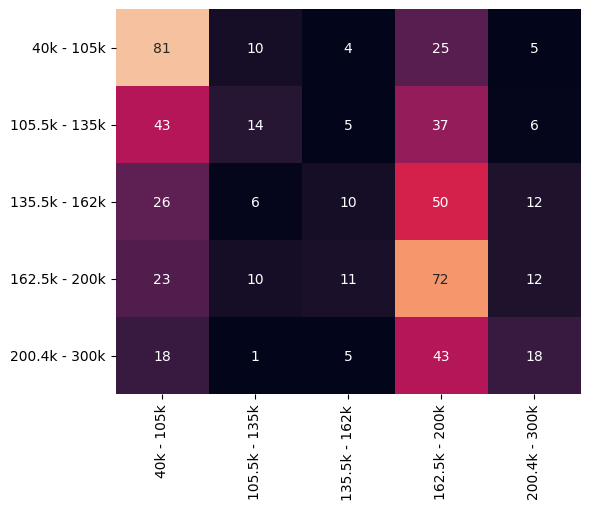

In [11]:
plot_confusion_matrix(lr, 'Logistic Regression Confusion Matrix')

#### DecisionTreeClassifier

In [12]:
dt = DecisionTreeClassifier(min_samples_split = 2, max_depth=20, random_state=42)

fit_and_compute_results(dt)

Training Accuracy is : 0.9021286441462286

Testing Accuracy is : 0.7806215722120659

----------------------------------------------------------------------------------------------------
Classification report w.r.t the train set:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       904
           1       0.85      0.92      0.89       847
           2       0.90      0.86      0.88       854
           3       0.89      0.90      0.89       997
           4       0.96      0.87      0.92       720

    accuracy                           0.90      4322
   macro avg       0.91      0.90      0.90      4322
weighted avg       0.90      0.90      0.90      4322


----------------------------------------------------------------------------------------------------
Classification report w.r.t the test set:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       125
           1       0.73    

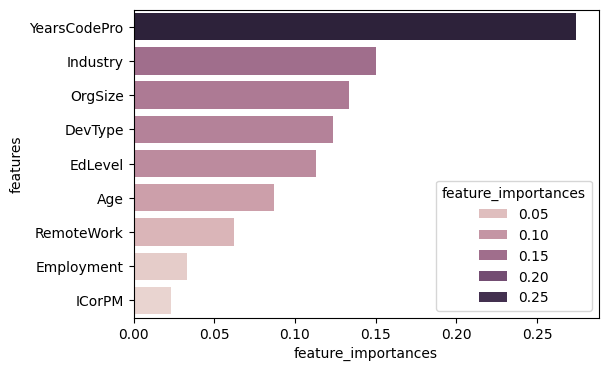

In [13]:
plot_feature_importances(dt)

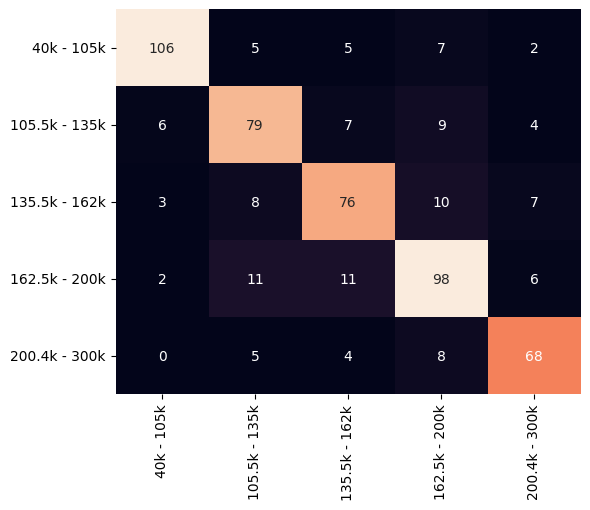

In [14]:
plot_confusion_matrix(dt, 'Decision Tree Confusion Matrix')

#### RandomForest Classifier

In [15]:
rf = RandomForestClassifier(n_estimators=500, min_samples_split=5,random_state=42)

fit_and_compute_results(rf)

Training Accuracy is : 0.9134659879685331

Testing Accuracy is : 0.7952468007312614

----------------------------------------------------------------------------------------------------
Classification report w.r.t the train set:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       904
           1       0.91      0.89      0.90       847
           2       0.94      0.87      0.90       854
           3       0.91      0.93      0.92       997
           4       0.93      0.92      0.92       720

    accuracy                           0.91      4322
   macro avg       0.91      0.91      0.91      4322
weighted avg       0.91      0.91      0.91      4322


----------------------------------------------------------------------------------------------------
Classification report w.r.t the test set:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       125
           1       0.79    

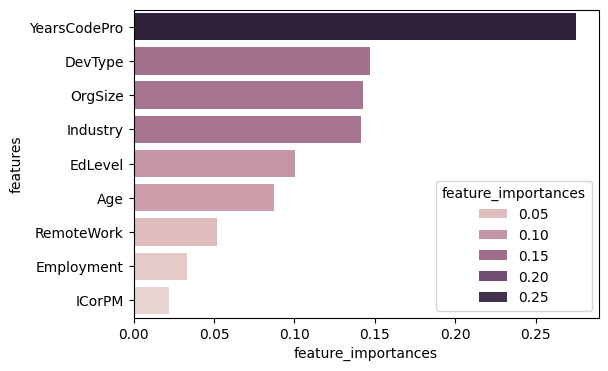

In [16]:
plot_feature_importances(rf)

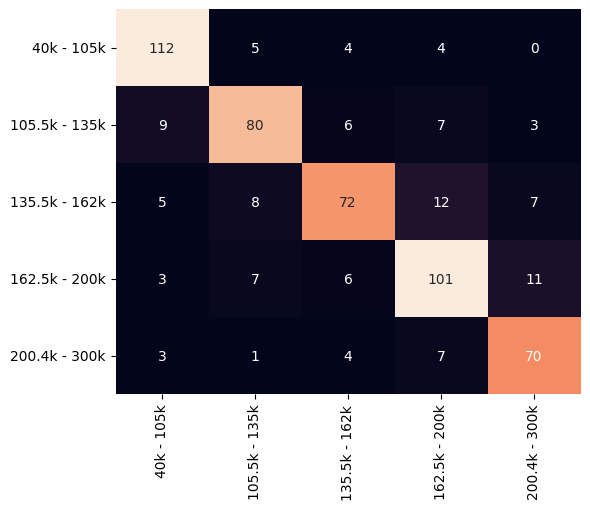

In [17]:
plot_confusion_matrix(rf, 'Random Forest Confusion Matrix')

#### Gradient Boosting Classifier

In [18]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=20, random_state=42)

fit_and_compute_results(gbc)

Training Accuracy is : 0.9562702452568256

Testing Accuracy is : 0.8354661791590493

----------------------------------------------------------------------------------------------------
Classification report w.r.t the train set:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       904
           1       0.93      0.96      0.95       847
           2       0.96      0.94      0.95       854
           3       0.95      0.96      0.96       997
           4       0.97      0.96      0.97       720

    accuracy                           0.96      4322
   macro avg       0.96      0.96      0.96      4322
weighted avg       0.96      0.96      0.96      4322


----------------------------------------------------------------------------------------------------
Classification report w.r.t the test set:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       125
           1       0.79    

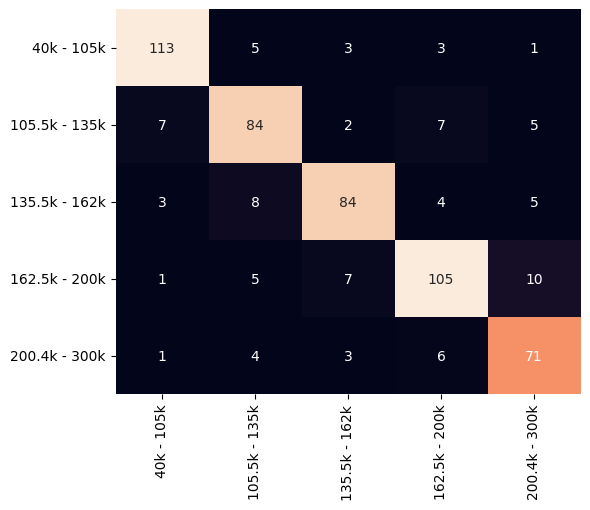

In [19]:
plot_confusion_matrix(gbc, 'Gradient Boosting Classifer Confusion Matrix')

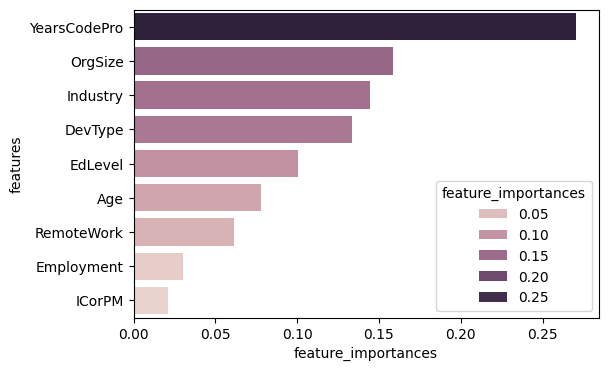

In [20]:
plot_feature_importances(gbc)

#### Hybrid Classifier

In [21]:
hybrid_classifier = VotingClassifier(estimators=[
        ('rf', rf), 
        ('tree',dt),
        ('gbc', gbc)], voting='soft')

fit_and_compute_results(hybrid_classifier)

Training Accuracy is : 0.9562702452568256

Testing Accuracy is : 0.8391224862888482

----------------------------------------------------------------------------------------------------
Classification report w.r.t the train set:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       904
           1       0.94      0.95      0.94       847
           2       0.95      0.94      0.95       854
           3       0.96      0.96      0.96       997
           4       0.97      0.96      0.97       720

    accuracy                           0.96      4322
   macro avg       0.96      0.96      0.96      4322
weighted avg       0.96      0.96      0.96      4322


----------------------------------------------------------------------------------------------------
Classification report w.r.t the test set:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       125
           1       0.80    

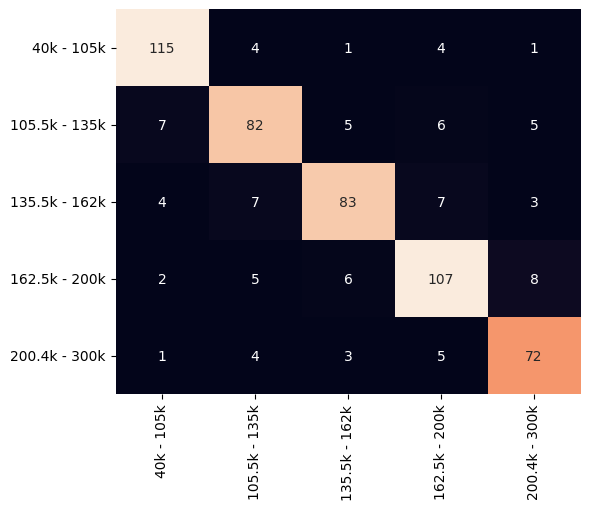

In [22]:
plot_confusion_matrix(hybrid_classifier, 'Hybrid Classifer Confusion Matrix')